### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Solution to Problem 1 
---

#### Part I 
---

We want to find $A_{12}$ and $A_{21}$ such that the function $p$ is able to approximate the equlibrial pressure for two given liquid (water and 1,4-dioxane). 

The optimization problem is to find parameters $A_{12}$ and $A_{21}$ such that the function $P\;(X; A_{12}, A_{21})$ approaches the measured data provided in the problem. The objective function can be formulated as the least square sum of the difference between the predicted and measured data, as follows:

$$
\begin{aligned}
&\text{minimize:} && \sum_{i=1}^{N = 11} (P\;(X_i; A_{12}, A_{21}) - P_i)^2  \\
&A_{12}, A_{21}
\end{aligned}
$$
where, 

$X = (x_1, x_2)$

---
#### Part II
---

Solving using gradient descent. Gradient descent with step size ($\alpha = 0.001$) is picked and the gradient is calculated through back propagation using PyTorch's autograd feature. The code below can be executed to obtain the optimized parameter $A$.  

In [1]:
import torch as t
from torch.autograd import Variable
import numpy as np


# Data Points
xi = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Binary, calculate x2 from x1
var = lambda x :  [x, 1-x]

# Define a variable, make sure requires_grad=True so that PyTorch can take gradient with respect to this variable
# make (x1, x2) from the given data points
x = t.from_numpy(np.array(list((map(var, xi)))))

# Define variable to optimize
a = Variable(t.tensor([1.0 , 1.0 ]), requires_grad=True)

# calculate psat values for water and 1,4-dioxane
def psat(liq):
    if liq == "water":
        a1 = 8.07131
        a2 = 1730.63
        a3 = 233.426
    else:
        a1 = 7.43155
        a2 = 1554.679
        a3 = 240.337
    
    return (10**(a1 - (a2/(20+a3))))

# Define loss as least square sum 
def lse_loss(x, y, a):
    A = a.clone()
    pi = lambda x, a: x[0]*t.exp(a[0]*((a[1]*x[1])/(a[0]*x[0]+a[1]*x[1]))**2)*psat("water") \
        + x[1]*t.exp(a[1]*((a[0]*x[0])/(a[0]*x[0]+a[1]*x[1]))**2)*psat("dioxane") 
    
    # stack the estimated value
    p = t.stack([pi(x[i], A) for i in range(x.size()[0])])
    
    return t.mm((p - y).reshape(1, -1), 
                (p - y).reshape(1, -1).t())


def lin_search(f, grad, x, a):
    tilt = 0.8
    alpha = 1
    d = -grad
    x = x[0]
    while f(x, a+alpha*d) > (f(x,a)+tilt*alpha*np.matmul(grad.t(), d)):
        alpha *= tilt
    return alpha
    

# measured data : y
y = t.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])


# Equlibrium pressure formula
pi = lambda x, a: x[0]*t.exp(a[0]*((a[1]*x[1])/(a[0]*x[0]+a[1]*x[1]))**2)*psat("water") \
        + x[1]*t.exp(a[1]*((a[0]*x[0])/(a[0]*x[0]+a[1]*x[1]))**2)*psat("dioxane") 

# Fix the step size
alpha = 0.001


# Start gradient descent
for i in range(100):  # TODO: change the termination criterion
    loss = lse_loss(x, y, a)
    
    #loss = a[0]
    loss.backward(retain_graph=True)
    
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x
    with t.no_grad():
        #t.autograd.set_detect_anomaly(True)
        #alpha = lin_search(pi, a.grad, x, a)
        a -= alpha * a.grad
        # need to clear the gradient at every step, or otherwise it will accumulate...
        #print(loss.data.numpy())
        a.grad.zero_()
            
print(a.data.numpy())
print(loss.data.numpy())


# Check the gradient. numpy() turns the variable from a PyTorch tensor to a numpy array.
#a.grad.numpy()

[1.9584178 1.6891867]
[[0.67019307]]


---

**The value of $A$ was found to be:**

$[A_{12}, A_{21}] = [1.9584178, \;\; 1.6891867]$ 


---

with the loss of $0.67019307$. 

The gradient descent algorithm converged to this particular local minimum and couldn't update further. 


#### Part III
---

In [2]:
print("Estimated Value with A =", a.data.numpy())

print ('------')
print(t.stack([pi(x[i], a) for i in range(x.size()[0])]).detach().numpy())

Estimated Value with A = [1.9584178 1.6891867]
------
[28.82409953 34.64431155 36.45296627 36.86731277 36.87400692 36.74983378
 36.39044727 35.38482398 32.94778604 27.73000205 17.47325208]


The Estimated value is determined and compared below (rounded to nearest ten):

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |
|$p_{est}$| 28.8 | 34.6 | 36.5 | 36.9 | 36.9 | 36.8 | 36.4 | 35.4 | 33.0 | 27.7 | 17.5 |


The Model has fit the data well with the squared error of about $0.67$. The model could perform even better if we provide more data. With the data fed to the algorithm, there is a high probability that the model has overfit the data. To avoid overfitting, feeding huge datasets usually helps among several other options. 


### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).


#### Solution to Problem 2
---

The bayesian optimization library provided in the tutorial above is used to solve the optimization problem. Bayesian optimization works by sampling an unknown function at several different points in the space such that the points are "spread-out" over the space. As the iteration increases, this optimization process finds the region of space that has minimum functional value compared to the the previous position. It is an heuristic process and does not guarantee convergence, however, it can be used to "improve" the current best solution. 

---
**Below is the code borrowed from the [tutorial](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).**

---

In [3]:
""" gp.py
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

We define the objective function and its bounds as provided in the problem statement. Since, bayesian optimization process stores all the functional values sampled until the last iteration, we can query the minimum value and the index of the minimum value to find the parameter corresponding minimum value. 

In [48]:
# Define the objective function
def obj_f(x):
    return (4 - 2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

bounds = np.array([[-3, 3],[-2,2]])
xp, yp = bayesian_optimisation(n_iters=47, 
                               sample_loss=obj_f, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

In [49]:
xp, yp

(array([[ 0.09697612, -0.60445253],
        [-2.02608699, -1.90457813],
        [-1.38745031, -0.31171466],
        [-2.20171154, -1.99555376],
        [-2.50819131, -1.99943173],
        [-2.9577226 , -1.99912119],
        [-2.99860898, -1.76437286],
        [-2.99690928, -1.98490992],
        [ 2.98673774,  1.9859951 ],
        [ 2.99708787,  1.36259697],
        [ 2.36085574,  1.99809378],
        [ 2.99938986, -1.976032  ],
        [ 2.99555897, -1.31206416],
        [ 2.37867907, -1.99701792],
        [ 2.99733345,  1.8110451 ],
        [-2.9746949 ,  1.99944102],
        [-2.31230115,  1.99796823],
        [-2.99735226,  1.44101137],
        [ 2.99442698,  0.19212151],
        [ 0.09689871,  1.99734812],
        [ 2.00850505,  0.2604518 ],
        [-2.99903187,  0.14998653],
        [-2.99860789, -0.74008508],
        [ 0.57403237, -1.99723374],
        [ 2.99579278, -0.53075351],
        [-2.99535431,  0.79064467],
        [ 2.99765298, -1.76141096],
        [-1.02902807,  1.313

In [50]:
min_val = yp.min()
min_index = yp.argmin()

In [51]:
print("The solution is: ("+ str(xp[min_index][0]) + ", " + str(xp[min_index][1])+")" )
print("And, the loss is ", min_val)

The solution is: (0.09697611920343263, -0.6044525342204645)
And, the loss is  -0.9486768101858796


---
**NOTE**

It is to be noted that, this process produces different result for different runs. 

---

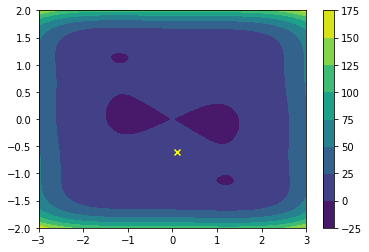

In [54]:
import matplotlib.pyplot as plt

x = np.linspace(-3,3,100)
y = np.linspace(-2,2,100)


X, Y = np.meshgrid(x, y)

z_params = [[x1, x2] for x1 in x for x2 in y]

Z = [obj_f(params) for params in z_params] 


p = plt.contourf(X, Y, np.array(Z).reshape(X.shape))
plt.scatter(xp[min_index][0], xp[min_index][1], marker='x', color='yellow')
plt.colorbar(p)


We can see the objective function in the plot above and locate the point found using the Bayesian optimization. We see that the point changes with every run and iteration as the process is stochastic. 